In [ ]:
# This is the basic proportional rate diffusion model from Palmer, Huk and Shadlen '05. 
# The overall fits are good for subject accuracies but mRT fits are not very good. 
# More specifically, the lowering of mRTs observed at low distance and high coherence 
# is not captured by the model.

# I am imposing the constraint that all parameters be positive.

In [1]:
## These are the pre-modelling steps where behavioral data is extracted from files.

# Load all required libraries
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import factorial as fact
# List subjects to fit
subs = ['Sub01', 'Sub02', 'Sub04', 'Sub05', 'Sub06', 'Sub08', 'Sub10', 'Sub11', 'Sub13']
nSub = len(subs)

# Define number of coherences per distance
nC = 4
# Define number of distances per coherence
nD = 4

# Initialize arrays to hold PC, mean and SD of RT, and # trials 
# for each coherence-distanct combination
# These values are obtained from the .csv files
pCs = np.zeros((nC*nD, nSub))
mRTs = np.zeros((nC*nD, nSub))
sdRTs = np.zeros((nC*nD, nSub))
Ns = np.zeros((nC*nD, nSub))

# Initialise a variable to hold # correct trials
# This will be computed from Ns and pCs
Rs = np.zeros((nC*nD, nSub))

# Extract behavioral data (PC, mean and SD of RT, # trials) from csv files
for si in range(nSub):
    csvFile = '../Data/Behavior/' + subs[si] + '_behavData.csv'
    behavData = pd.read_csv(csvFile, header=None)
    
    # Split the file in PC, mean RT and SD RT
    # Flatten each subject's values for ease of programming
    temp = np.array(behavData[0:4])
    pCs[:,si] = temp[:,:-1].flatten()
    temp = np.array(behavData[4:8])
    mRTs[:,si] = temp[:,:-1].flatten()
    temp = np.array(behavData[8:12])
    sdRTs[:,si] = temp[:,:-1].flatten()
    temp = np.array(behavData[12:])
    Ns[:,si] = temp[:,:-1].flatten()
    Rs[:,si] = np.round(Ns[:,si] * pCs[:,si])

In [ ]:
# Parameters to fit:
# A: Boundary
# x: Stimulus strength
# k: Proportionality constant (Stim. str. = kx)
# tR: Residual time

# Equations to fit for each stimulus strength:
# pC = 1 / (1+exp(-2*A*k*abs(x)))
# mRT = A / (k*x) * tanh(A*k*x) + tR

# We can get approximate values for A, k and tR from Palmer et. al. '05
# Ranges of parameters to start with:
# A: 0.5 - 1
# k: 5 - 40
# tR: 0.25 - 0.5 (in seconds)
# x: 0 - 1

# To identify best fit, calculate the likelihood of predicted pC and mRT and find the maximum likelihood.

# Likelihood of pC follows a binomial distribution
# Lp = n! / (r!(n-r)! * pC(x)^r * (1-pC(x))^(n-r), where
# n = # trials, r = # required correct

# Likelihood of mRT follows a Gaussian distribution
# Lrt = 1 / (SDrt * (sqrt(2*pi))) * e^-((mRT(x) - oRT(x)) / SDrt)^2 * 1/2, where
# oRT = observed mRT, mRT = predicted mRT, SDrt = SD of predicted mRT

# VARrt = VARtd + VARtr, where
# VARtd = variance in decision time, VARtr = variance in residual time. Thus,
# VARrt = (A * tanh(A*k*x) - A*k*x * sech(A*k*x)) / (k*x)^3 + (0.1 * tR)^2

# Final fit measure is the log likelihood, which is the sum of the likelihoods of accuracy and mean RT, 
# over all combinations of coherence and distance
# Lprt = sigma(x)(ln(Lp(s)) + ln(Lrt(x)))

# The first pass of the model will be to estimate values of x without any assumptions about stimulus relationtips.
# The stopping point will be the point of least error.

In [2]:
## First run of the model. 

Amin = 0.1
kmin = 0.001
tRmin = 0

# Initialize A, k and tR parameters
A, dA = np.linspace(Amin, 3, 10, retstep=True)
# k, dk = np.linspace(0.3, 2, 20, retstep=True)
k, dk = np.linspace(kmin, 2, 10, retstep=True)
tR, dtR = np.linspace(tRmin, 2, 7, retstep=True)

As, ks, tRs = np.meshgrid(A, k, tR)
As = As.flatten()
ks = ks.flatten()
tRs = tRs.flatten()

# This is the overall number of permutations of A, k and tR being performed
nPar = len(As)

# Initialize stimulus strength parameter
dx = 0.02
x = np.arange(0.01, 8, dx)

# Initialize arrays that hold predicted accuracies and RTs
epc = np.ones((nPar, len(x), nC*nD, nSub)) * -9
ert = np.ones((nPar, len(x), nC*nD, nSub)) * -9
sdrt = np.ones((nPar, len(x), nC*nD, nSub)) * -9

## Initialize the array that holds the
# individual likelihood values
lpc = np.zeros((nPar, len(x), nC*nD, nSub))
lrt = np.zeros((nPar, len(x), nC*nD, nSub))


## Now run the model using the parameters defined above

# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in range(nPar):
        for cdi in range(nC*nD):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,:,cdi,si] = 1 / (1 + np.exp(-2 * As[pi] * ks[pi] * abs(x)))
            # And the likelihood of this accuracy
            lpc[pi,:,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,:,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,:,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))
            
            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,:,cdi,si] = As[pi] / (ks[pi] * x) * np.tanh(As[pi] * ks[pi] * x) + tRs[pi] 
            # And standard error of the mean
            sdrt[pi,:,cdi,si] = np.sqrt(((As[pi] * np.tanh(As[pi] * ks[pi] * x) - \
                    As[pi] * ks[pi] * x * (1/np.cosh(np.square(As[pi] * ks[pi] * x)))) / \
                    (ks[pi] * x) ** 3 + np.square(0.1 * tRs[pi])) / Ns[cdi,si])
            # And the likelihood of observing that RT
            lrt[pi,:,cdi,si] = 1 / (sdrt[pi,:,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,:,cdi,si] - mRTs[cdi,si]) / sdrt[pi,:,cdi,si]))

# Find the set of best x values for each parameter combination and
# then calculate the total log-likelihood for each parameter combination

bestXcd = np.ones((nPar, nC*nD, nSub), dtype = np.int) * -9
totLL = np.zeros((nPar, nSub))
for si in range(nSub):
    for pi in range(nPar):
        # At each A-k-tR combination, find the index of x value 
        # that maximizes likelihood for each CD combination
        bestXcd[pi,:,si] = np.argmax(lpc[pi,:,:,si] * lrt[pi,:,:,si],0)
        for cdi in range(nC*nD):
            # Sum over all CDs to obtain overall likelihood for the 
            # given A-k-tR combination
            totLL[pi,si] += np.log(lpc[pi,bestXcd[pi,cdi,si],cdi,si]) + \
                                np.log(lrt[pi,bestXcd[pi,cdi,si],cdi,si])

# Find the parameters for which total log-likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub, dtype = np.int)

# Record the values of best fit x for each CD combination
bestx = np.zeros((nC*nD, nSub), dtype = np.int)
for si in range(nSub):
    maxParId[si] = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    bestx[:,si] = bestXcd[maxParId[si],:,si]

subXs = np.zeros((nC*nD, nSub))
for si in range(nSub):
    subXs[:,si] = x[bestx[:,si]].round(decimals=2)

In [3]:
for si in range(nSub):
    print(bestx[:,si].reshape((nC,nD)))

[[  8   6  11   4]
 [ 11  10  31  29]
 [  5  41  57  62]
 [  8  85 248 256]]
[[ 14   6  14  14]
 [  5  27  84  84]
 [ 14  46 115 118]
 [ 11  32 215 249]]
[[ 36  49  29  19]
 [ 38  28 125 117]
 [ 23  99 201 243]
 [ 11 132 310 377]]
[[ 17  19  11   8]
 [  8  15  46  62]
 [ 18  41 130 127]
 [ 12  33 189 261]]
[[  8   9  10   7]
 [ 17  37  84  99]
 [  9  59 154 144]
 [ 11 110 263 282]]
[[ 45  53  14  14]
 [ 59  71  92 111]
 [ 26  68 122 152]
 [ 29 132 299 399]]
[[ 15  13  11  15]
 [ 14  29  62  92]
 [ 11  30 135 153]
 [ 12  53 170 266]]
[[ 27  20  14  16]
 [ 30  76 128 183]
 [ 36  61 279 318]
 [ 17 110 269 399]]
[[ 16   9  21  10]
 [  7  20  17  28]
 [ 15  20  25  19]
 [ 14 105 188 223]]


In [4]:
print(x[bestx])

[[ 0.17  0.29  0.73  0.35  0.17  0.91  0.31  0.55  0.33]
 [ 0.13  0.13  0.99  0.39  0.19  1.07  0.27  0.41  0.19]
 [ 0.23  0.29  0.59  0.23  0.21  0.29  0.23  0.29  0.43]
 [ 0.09  0.29  0.39  0.17  0.15  0.29  0.31  0.33  0.21]
 [ 0.23  0.11  0.77  0.17  0.35  1.19  0.29  0.61  0.15]
 [ 0.21  0.55  0.57  0.31  0.75  1.43  0.59  1.53  0.41]
 [ 0.63  1.69  2.51  0.93  1.69  1.85  1.25  2.57  0.35]
 [ 0.59  1.69  2.35  1.25  1.99  2.23  1.85  3.67  0.57]
 [ 0.11  0.29  0.47  0.37  0.19  0.53  0.23  0.73  0.31]
 [ 0.83  0.93  1.99  0.83  1.19  1.37  0.61  1.23  0.41]
 [ 1.15  2.31  4.03  2.61  3.09  2.45  2.71  5.59  0.51]
 [ 1.25  2.37  4.87  2.55  2.89  3.05  3.07  6.37  0.39]
 [ 0.17  0.23  0.23  0.25  0.23  0.59  0.25  0.35  0.29]
 [ 1.71  0.65  2.65  0.67  2.21  2.65  1.07  2.21  2.11]
 [ 4.97  4.31  6.21  3.79  5.27  5.99  3.41  5.39  3.77]
 [ 5.13  4.99  7.55  5.23  5.65  7.99  5.33  7.99  4.47]]


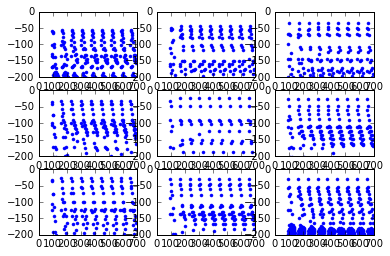

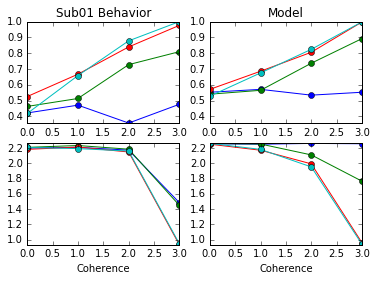

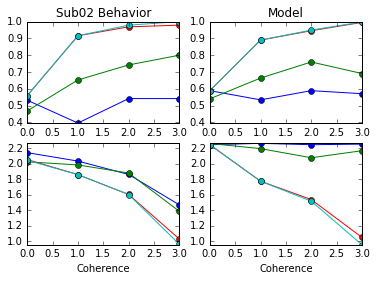

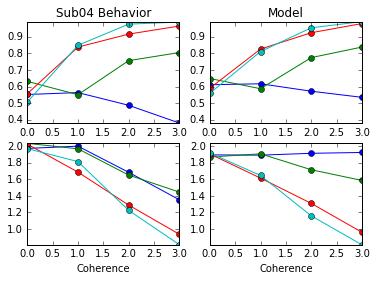

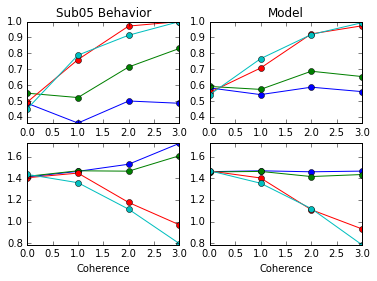

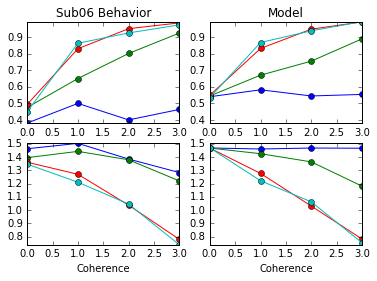

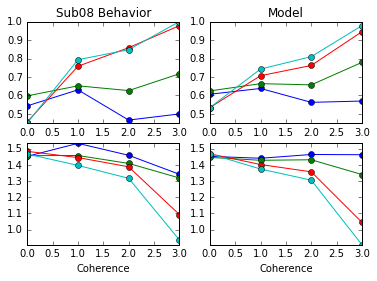

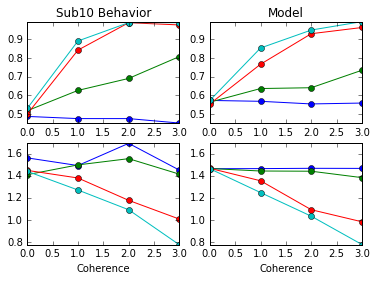

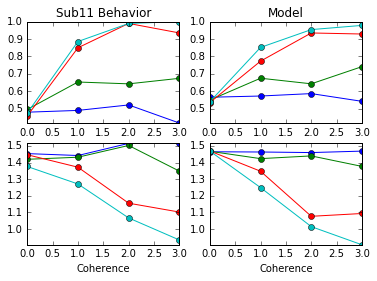

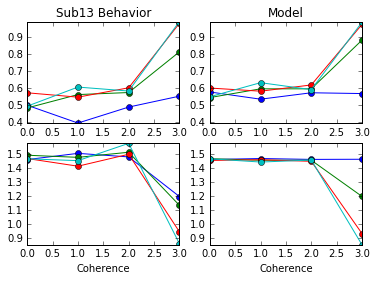

In [5]:
## And now for some plots

# Plot the total log-likelihood values obtained for each subject
plt.figure()
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')
    plt.ylim(-200, 0)
    
# Plot the observed (behavior) and expected (model) PC and RT
for si in range(nSub):
    temp = []
    ymin = min(pCs[:,si])
    ymax = max(pCs[:,si])
    for cdi in range(nC*nD):
        temp.append(epc[maxParId[si], bestx[cdi,si], cdi, si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(nC,nD)),'o-')
    plt.ylim((ymin, ymax))
    
    plt.subplot(222)
    plt.title('Model')
    plt.plot(np.reshape(temp,(nC,nD)),'o-')
    plt.ylim((ymin,ymax))

    temp = []
    ymin = min(mRTs[:,si])
    ymax = max(mRTs[:,si])
    for cdi in range(nC*nD):
        temp.append(ert[maxParId[si], bestx[cdi,si], cdi, si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(nC,nD)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')
    
    plt.subplot(224)
    plt.plot(np.reshape(temp,(nC,nD)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')
    
    fname = 'run1fit_' + subs[si] + '.eps'
    plt.savefig(fname, format = 'eps')

In [6]:
sumLL = np.zeros((nC*nD, nSub))
for si in range(nSub):
    sumLL[0,si] = totLL[maxParId[si],si]

In [7]:
print(sumLL[0,:].round(decimals=2))

[-55.03 -44.17 -34.92 -31.31 -22.94 -24.87 -27.   -30.45 -28.75]


In [8]:
# Run 2 of the model

minA = np.zeros(nSub)
maxA = np.zeros(nSub)
mink = np.zeros(nSub)
maxk = np.zeros(nSub)
mintR = np.zeros(nSub)
maxtR = np.zeros(nSub)

nd = 3 # Number of deltas before and after best fit value

for si in range(nSub):
    # Set up A, k and tR parameters for the next round of simulations
    # Use the bestx values from the first run, don't fit for x again
    
    # First set the range of all variables. 
    # minVar = bestValue - dVar*nd : bestValue + dVar*nd
    # If the new minimum is <= 0, then set it to the old minimum.
    minA[si] = As[maxParId[si]] - nd * dA
    maxA[si] = As[maxParId[si]] + nd * dA
    if minA[si] < 0:
        minA[si] = A[0]
    
    mink[si] = ks[maxParId[si]] - nd * dk
    maxk[si] = ks[maxParId[si]] + nd * dk
    if mink[si] < 0:
        mink[si] = k[0]
        
    mintR[si] = tRs[maxParId[si]] - nd * dtR
    maxtR[si] = tRs[maxParId[si]] + nd * dtR
    if mintR[si] < 0:
        mintR[si] = tR[0]

# Set up the parameter meshgrid
nStep = 9 # Number of values tested, per parameter

A = np.zeros((nStep, nSub))
dA = np.zeros(nSub)
k = np.zeros((nStep, nSub))
dk = np.zeros(nSub)
tR = np.zeros((nStep, nSub))
dtR = np.zeros(nSub)

# This is the overall number of permutations of A, k and tR being performed
nPar = nStep ** 3

As = np.zeros((nPar, nSub))
ks = np.zeros((nPar, nSub))
tRs = np.zeros((nPar, nSub))

for si in range(nSub):
    A[:,si], dA[si] = np.linspace(minA[si], maxA[si], nStep, retstep=True)
    k[:,si], dk[si] = np.linspace(mink[si], maxk[si], nStep, retstep=True)
    tR[:,si], dtR[si] = np.linspace(mintR[si], maxtR[si], nStep, retstep=True)

    tempAs, tempks, temptRs = np.meshgrid(A[:,si], k[:,si], tR[:,si])
    As[:,si] = tempAs.flatten()
    ks[:,si] = tempks.flatten()
    tRs[:,si] = temptRs.flatten()
    
    # Initialize arrays that hold predicted accuracies and RTs
    epc = np.ones((nPar, nC*nD, nSub)) * -9
    ert = np.ones((nPar, nC*nD, nSub)) * -9
    sdrt = np.ones((nPar, nC*nD, nSub)) * -9

    ## Initialize the array that holds the
    # individual likelihood values
    lpc = np.zeros((nPar, nC*nD, nSub))
    lrt = np.zeros((nPar, nC*nD, nSub))
    
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in range(nPar):
        for cdi in range(nC*nD):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,cdi,si] = 1 / (1 + np.exp(-2 * As[pi,si] * ks[pi,si] * abs(x[bestx[cdi,si]])))

            # Calculate likelihood of accuracy for this CD combination
            lpc[pi,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))
            
            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,cdi,si] = As[pi,si] / (ks[pi,si] * x[bestx[cdi,si]]) * \
                                np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) + tRs[pi,si] 
            # Calculate SD of mean RT 
            sdrt[pi,cdi,si] = np.sqrt(((As[pi,si] * np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) - \
                    As[pi,si] * ks[pi,si] * x[bestx[cdi,si]] * \
                    (1/np.cosh(np.square(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]])))) / \
                    (ks[pi,si] * x[bestx[cdi,si]]) ** 3 + np.square(0.1 * tRs[pi,si])) / Ns[cdi,si])
            # Calculate likelihood of mean RT for this CD combination
            lrt[pi,cdi,si] = 1 / (sdrt[pi,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,cdi,si] - mRTs[cdi,si]) / sdrt[pi,cdi,si]))
                
# Calculate the total log-likelihood for each parameter combination
totLL = np.zeros((nPar, nSub))
for si in range(nSub):
    for pi in range(nPar):
        for cdi in range(nC*nD):
            totLL[pi,si] += np.log(lpc[pi,cdi,si]) + np.log(lrt[pi,cdi,si])

# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub, dtype = np.int)
for si in range(nSub):
    maxParId[si] = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    
# Make a note of the sum of total LLs of all subjects. Stop the simulation when sumLL
# reaches a cutoff point
for si in range(nSub):
    sumLL[1,si] = totLL[maxParId[si],si]

In [9]:
print(sumLL[0:2,:].round(decimals=2))

[[-55.03 -44.17 -34.92 -31.31 -22.94 -24.87 -27.   -30.45 -28.75]
 [-56.3  -46.09 -34.92 -32.71 -24.87 -24.87 -28.63 -30.45 -29.8 ]]


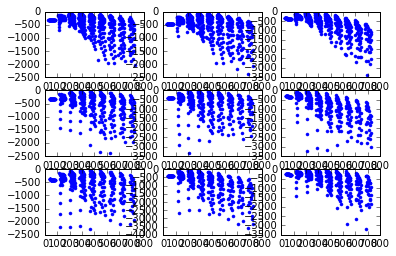

In [10]:
plt.figure()
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')


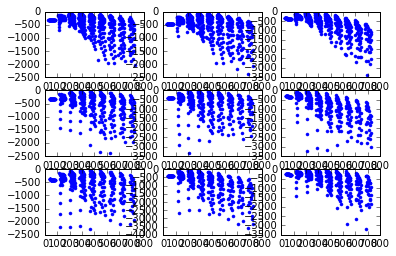

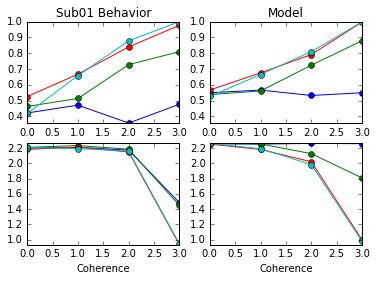

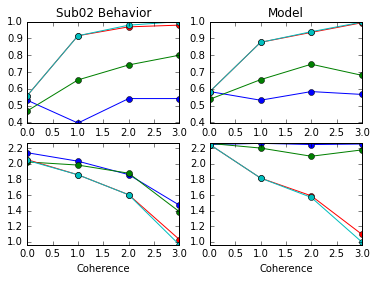

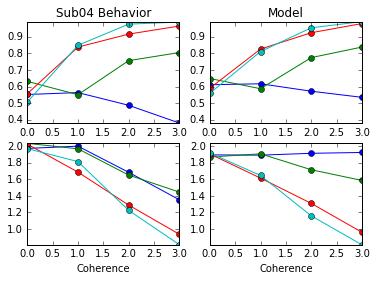

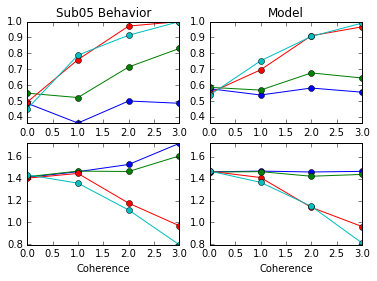

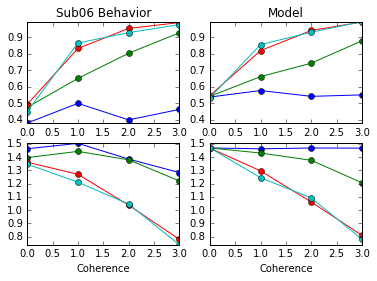

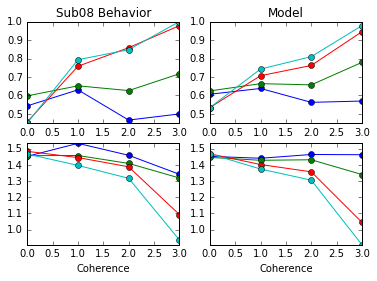

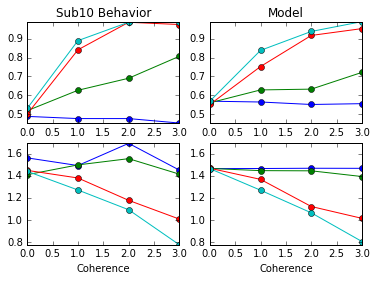

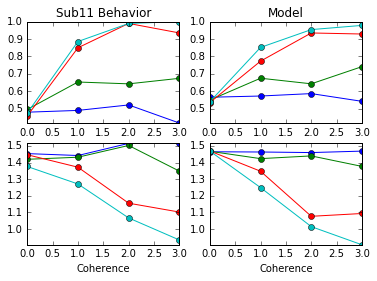

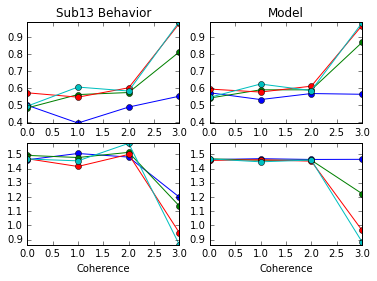

In [11]:
## And now for some plots

# Plot the total log-likelihoods for each subject
plt.figure()
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')
    
# Plot the observed (behavior) and expected (model) PC and RT
for si in range(nSub):
    temp = []
    ymin = min(pCs[:,si])
    ymax = max(pCs[:,si])
    for cdi in range(nC*nD):
        temp.append(epc[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(nC,nD)),'o-')
    plt.ylim((ymin, ymax))
    
    plt.subplot(222)
    plt.title('Model')
    plt.plot(np.reshape(temp,(nC,nD)),'o-')
    plt.ylim((ymin,ymax))

    temp = []
    ymin = min(mRTs[:,si])
    ymax = max(mRTs[:,si])
    for cdi in range(nC*nD):
        temp.append(ert[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(nC,nD)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')
    
    plt.subplot(224)
    plt.plot(np.reshape(temp,(nC,nD)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')
    
    fname = 'run2fit_' + subs[si] + '.eps'
    plt.savefig(fname, format = 'eps')

In [12]:
# Save the values of the parameters and the likelihoods after the second run
pars = np.zeros((3, nSub))
lls = np.zeros(nSub)

for si in range(nSub):
    pars[0,si] = As[maxParId[si],si]
    pars[1,si] = ks[maxParId[si],si]
    pars[2,si] = tRs[maxParId[si],si]
    lls[si] = sumLL[1,si]

In [13]:
run = np.ones(nSub, dtype = np.int) * 2

for si in range(nSub):
    # Initialize the minimum and maximum values of the parameters
    mnA = As[maxParId[si],si] - nd * dA[si]
    mxA = As[maxParId[si],si] + nd * dA[si]
    if mnA < Amin:
        mnA = Amin

    mnk = ks[maxParId[si],si] - nd * dk[si]
    mxk = ks[maxParId[si],si] + nd * dk[si]
    if mnk < kmin:
        mnk = kmin

    mntR = tRs[maxParId[si],si] - nd * dtR[si]
    mxtR = tRs[maxParId[si],si] + nd * dtR[si]
    if mntR < tRmin:
        mntR = tRmin

    A_run = []
    k_run = []
    tR_run = []
    
    # This variable keeps track of whether the simulation should continue or not
    simStop = 0

    while simStop == 0:
        if mxA - mnA > 0.01 and mxk - mnk > 0.001 and mxtR - mntR > 0.01:
            # Create temporary parameter variables for each simulation run
            tA, tdA = np.linspace(mnA, mxA, nStep, retstep=True)
            tk, tdk = np.linspace(mnk, mxk, nStep, retstep=True)
            ttR, tdtR = np.linspace(mntR, mxtR, nStep, retstep=True)

            tempAs, tempks, temptRs = np.meshgrid(tA, tk, ttR)
            tAs = tempAs.flatten()
            tks = tempks.flatten()
            ttRs = temptRs.flatten()

            # Initialize arrays that hold predicted accuracies and RTs
            epc = np.ones((nPar, nC*nD)) * -9
            ert = np.ones((nPar, nC*nD)) * -9
            sdrt = np.ones((nPar, nC*nD)) * -9

            ## Initialize the array that holds the individual and total likelihood values
            lpc = np.zeros((nPar, nC*nD))
            lrt = np.zeros((nPar, nC*nD))
            totLL = np.zeros(nPar)

            # From the set of parameters, calculate the (expected) predicted PC and RT
            # and then find the likelihood that these estimates match the observed PC and RT
            for pi in range(nPar):
                # Calculate expected accuracy and RT for each coherence-distance combination
                epc[pi,:] = 1 / (1 + np.exp(-2 * tAs[pi] * tks[pi] * abs(x[bestx[:,si]])))
                ert[pi,:] = tAs[pi] / (tks[pi] * x[bestx[:,si]]) * np.tanh(tAs[pi] * tks[pi] * x[bestx[:,si]]) + ttRs[pi] 
                for cdi in range(nC*nD):
                    # Calculate likelihood of accuracy for this CD combination
                    lpc[pi,cdi] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                        (epc[pi,cdi] ** Rs[cdi,si]) * \
                                        ((1 - epc[pi,cdi]) ** (Ns[cdi,si] - Rs[cdi,si]))

                    # Calculate SD of mean RT 
                    sdrt[pi,cdi] = np.sqrt(((tAs[pi] * np.tanh(tAs[pi] * tks[pi] * x[bestx[cdi,si]]) - \
                                             tAs[pi] * tks[pi] * x[bestx[cdi,si]] * \
                                             (1/np.cosh(np.square(tAs[pi] * tks[pi] * x[bestx[cdi,si]])))) / \
                                            (tks[pi] * x[bestx[cdi,si]]) ** 3 + np.square(0.1 * ttRs[pi])) / Ns[cdi,si])

                    # Calculate likelihood of mean RT for this CD combination
                    lrt[pi,cdi] = 1 / (sdrt[pi,cdi] * np.sqrt(2 * np.pi)) * \
                                        np.e ** (-1/2 * np.square((ert[pi,cdi] - mRTs[cdi,si]) / sdrt[pi,cdi]))

                # Calculate the total log-likelihood for each parameter combination
                totLL[pi] = np.sum(np.log(lpc[pi,:])) + np.sum(np.log(lrt[pi,:]))

            # Find the parameters for which likelihood is maximum
            # There are some NaN values in the likelihood matrix so exclude those
            ids = np.where(totLL == np.nanmax(totLL))[0]
            if len(ids) == 0:
                simStop = 1
            elif len(ids) > 1:
                parId = ids[0]
            else:
                parId = ids

            # Check to see if the simulation should continue for another run
            if simStop == 1 or \
            (totLL[parId] > sumLL[run[si]-1,si] and abs(sumLL[run[si]-1,si] - totLL[parId]) <= 0.1) or \
            (totLL[parId] < sumLL[run[si]-1,si] and abs(sumLL[run[si]-1,si] - totLL[parId]) > 15):
                simStop = 1
            else:
                sumLL[run[si],si] = totLL[parId]
                run[si] += 1

            A_run.append(tAs[parId])
            k_run.append(tks[parId])
            tR_run.append(ttRs[parId])

            # Re-initialize the minimum and maximum values of parameters for the next run
            mnA = tAs[parId].round(decimals=3) - nd * tdA.round(decimals=3)
            mxA = tAs[parId].round(decimals=3) + nd * tdA.round(decimals=3)

            mnk = tks[parId].round(decimals=3) - nd * tdk.round(decimals=3)
            mxk = tks[parId].round(decimals=3) + nd * tdk.round(decimals=3)

            mntR = ttRs[parId].round(decimals=3) - nd * tdtR.round(decimals=3)
            mxtR = ttRs[parId].round(decimals=3) + nd * tdtR.round(decimals=3)

            if mnA < Amin:
                mnA = Amin
            if mnk < kmin:
                mnk = kmin
            if mntR < tRmin:
                mntR = tRmin
        else:
            simStop = 1
            
    if run[si] > 2:
        pars[0,si] = A_run[-1]
        pars[1,si] = k_run[-1]
        pars[2,si] = tR_run[-1]
        lls[si] = sumLL[run[si]-1,si]

/Users/Swetha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Swetha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Swetha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:112: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [14]:
run

array([ 4.,  6.,  8.,  5.,  4.,  7.,  4.,  4.,  5.])

In [15]:
sumLL.round(decimals=1)
#[-55.08 -36.8  -38.87 -35.18 -31.78 -35.9  -28.01 -35.34 -37.58];

array([[-55. , -44.2, -34.9, -31.3, -22.9, -24.9, -27. , -30.5, -28.7],
       [-56.3, -46.1, -34.9, -32.7, -24.9, -24.9, -28.6, -30.5, -29.8],
       [-55.2, -45.2, -36.2, -26.3, -23.6, -25.3, -20.5, -33.2, -29. ],
       [-55.2, -45.2, -36.3, -26.3, -23.7, -24.1, -20.6, -29.9, -29.1],
       [  0. , -44.9, -36.3, -26.3,   0. , -23. ,   0. ,   0. , -29.1],
       [  0. , -44.5, -35.7,   0. ,   0. , -22.8,   0. ,   0. ,   0. ],
       [  0. ,   0. , -35.5,   0. ,   0. , -22.3,   0. ,   0. ,   0. ],
       [  0. ,   0. , -34.7,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. , 

In [16]:
lls.round(decimals=2)

array([-55.22, -44.45, -34.73, -26.3 , -23.65, -22.3 , -20.59, -29.94,
       -29.06])

In [18]:
print(np.sum(lls))
print(np.sum(np.array([-55. , -44.2, -34.9, -31.3, -22.9, -24.9, -27. , -30.5, -28.7])))

-286.252457808
-299.4


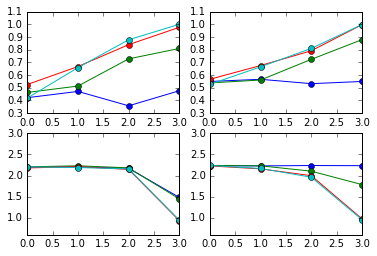

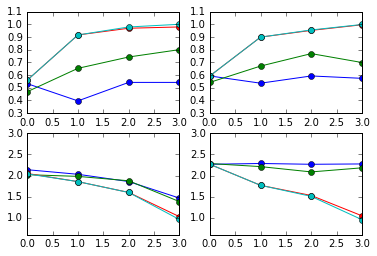

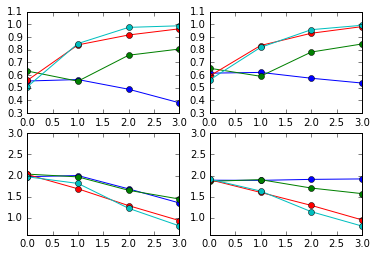

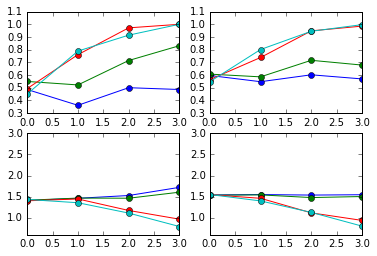

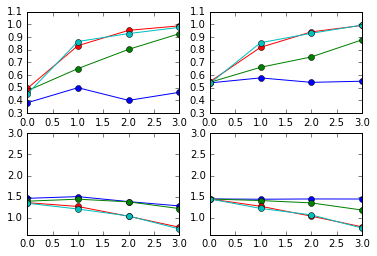

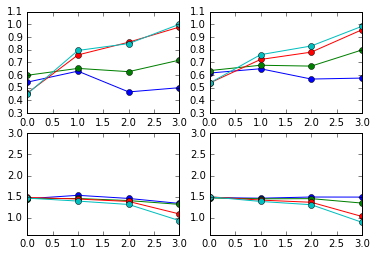

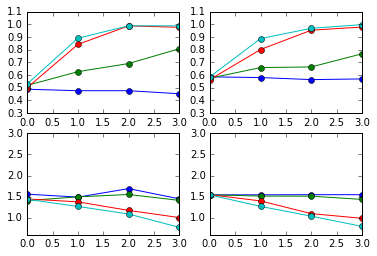

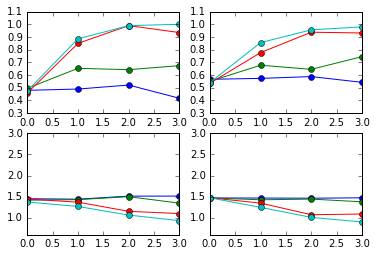

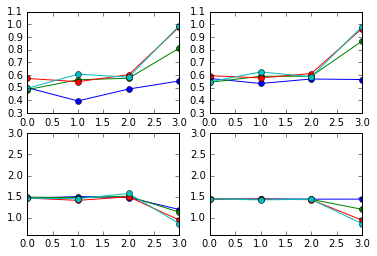

In [19]:
for si in range(nSub):
    pcFit = np.zeros((nC,nD))
    pcFit = np.zeros((nC,nD))
    rtFit = np.zeros((nC,nD))
    rtFit = np.zeros((nC,nD))
    
    temp = 1 / (1 + np.exp(-2 * pars[0,si] * pars[1,si] * abs(x[bestx[:,si]])))
    pcFit = temp.reshape((nC,nD))
    temp = pars[0,si] / (pars[1,si] * x[bestx[:,si]]) * np.tanh(pars[0,si] * pars[1,si] * x[bestx[:,si]]) + pars[2,si]
    rtFit = temp.reshape((nC,nD))
        
    ymin = 0.3
    ymax = 1.1
    plt.figure()
    plt.subplot(221)
    plt.plot(pCs[:,si].reshape((nC,nD)),'o-')
    plt.ylim((ymin,ymax))
    plt.subplot(222)
    plt.plot(pcFit,'o-')
    plt.ylim((ymin,ymax))
    
    ymin = 0.6
    ymax = 3
    plt.subplot(223)
    plt.plot(mRTs[:,si].reshape((nC,nD)),'o-')
    plt.ylim((ymin,ymax))
    plt.subplot(224)
    plt.plot(rtFit,'o-')
    plt.ylim((ymin,ymax))


In [20]:
# Final A values for each subject
pars[0,:].round(decimals=2)

array([ 1.39,  1.39,  1.37,  1.07,  1.07,  1.07,  1.07,  1.07,  1.07])

In [21]:
# Final k values for each subject
pars[1,:].round(decimals=2)

array([ 0.42,  0.46,  0.23,  0.52,  0.42,  0.24,  0.52,  0.23,  0.42])

In [22]:
# Final tR values for each subject
pars[2,:].round(decimals=2)

array([ 0.31,  0.36,  0.04,  0.42,  0.31,  0.36,  0.42,  0.34,  0.31])

In [ ]:
# Extract group behavioral data (PC, mean and SD of RT, # trials) from csv file
csvFile = '../Data/Behavior/All_behavData.csv'
behavData = pd.read_csv(csvFile, header=None)

# Split the file in PC, mean RT and SD RT
# Flatten each subject's values for ease of programming
pCs = np.array(behavData[0:4])
mRTs = np.array(behavData[4:8])

# Get the model fits of PC and mRT for each subject
fitPC = np.zeros((20,9))
fitRT = np.zeros((20,9))
for si in range(nSub):
    fitPC[:,si] = epc[maxParId[si],:,si]
    fitRT[:,si] = ert[maxParId[si],:,si]

mfitPC = np.mean(fitPC,1)
sdfitPC = np.std(fitPC,1)
mfitRT = np.mean(fitRT,1)
sdfitRT = np.std(fitRT,1)

ymin = np.min(pCs)
if ymin > np.min(mfitPC):
    ymin = np.min(mfitPC)
ymax = np.max(pCs)
if ymax < np.max(mfitPC):
    ymax = np.max(mfitPC)

ids = np.array([0, 5, 10, 15], dtype = np.int)

plt.subplot(221)
plt.title('Group behavior')
plt.plot(pCs,'o-')
plt.ylim((ymin - max(sdfitPC), ymax + max(sdfitPC)))
plt.subplot(222)
plt.title('Average fit')
for cdi in range(5):
    plt.errorbar(x = range(4), y = mfitPC[[ids + cdi]], yerr = sdfitPC[[ids + cdi]], fmt = 'o-')
plt.ylim((ymin - max(sdfitPC), ymax + max(sdfitPC)))

ymin = np.min(mRTs)
if ymin > np.min(mfitRT):
    ymin = np.min(mfitRT)
ymax = np.max(mRTs)
if ymax < np.max(mfitRT):
    ymax = np.max(mfitRT)

plt.subplot(223)
plt.plot(np.reshape(mRTs,(4,5)),'o-')
plt.ylim((ymin - max(sdfitRT), ymax + max(sdfitRT)))
plt.xlabel('Coherence')
plt.subplot(224)
for cdi in range(5):
    plt.errorbar(x = range(4), y = mfitRT[[ids + cdi]], yerr = sdfitRT[[ids + cdi]], fmt = 'o-')
plt.xlabel('Coherence')
plt.ylim((ymin - max(sdfitRT), ymax + max(sdfitRT)))

plt.savefig('groupFit.eps', format = 'eps')